In [1]:
%load_ext autoreload
%autoreload 2

In [763]:
from albumentations.augmentations.transforms import Resize
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
# Alias to avoid clash with fastai dataloader.
from torch.utils.data import Dataset, DataLoader as TorchDataLoader

from htools import *

In [3]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [33]:
dir_ = Path('data/imagewang-160/')
path_u = dir_/'unsup'

In [34]:
files_u = get_image_files(path_u)
len(files_u)

7750

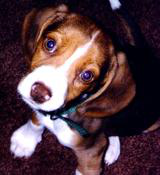

In [35]:
load_image(files_u[1])

In [36]:
WangBlock = DataBlock(blocks=([ImageBlock]*4),
                      splitter=(),
                      get_items=get_image_files,
                      splitter=GrandparentSplitter(), 
                      item_tfms=Resize(160))

In [37]:
bs = 4
db = WangBlock.dataloaders(path_u, bs=bs)

In [38]:
attrmap('shape', *db.one_batch())

[torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160])]

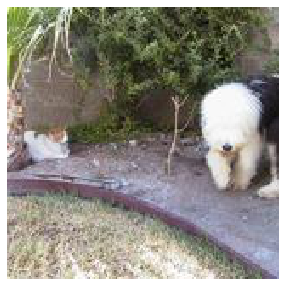

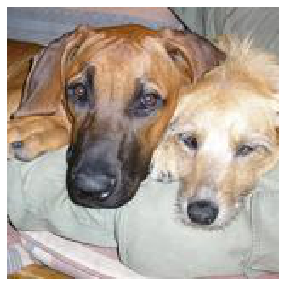

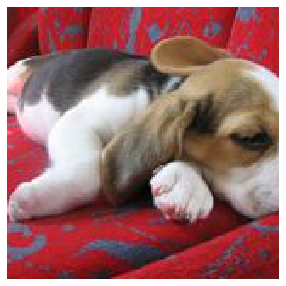

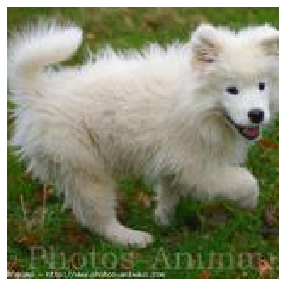

In [39]:
db.show_batch()

In [41]:
db.valid_ds

(#1550) [(PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160),(PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=160x239, PILImage mode=RGB size=160x239, PILImage mode=RGB size=

In [62]:
class ImageMixTransform(Transform):
    
    def __init__(self, files):
        self.files = files
    
    def encodes(self, i):
        files = self.files[i:i+3]
        return tuple(map(load_image, files))
    
    def show(self, ctx=None, **kwargs):
        pass

In [63]:
ttl = TfmdLists(range(len(files_u)), ImageMixTransform(files_u))

In [64]:
x, y, z = ttl[0]

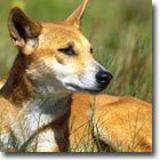

In [67]:
x

In [86]:
x = np.random.randint(5, size=4)
x / x.sum()

array([0.27272727, 0.27272727, 0.27272727, 0.18181818])

In [227]:
def rand_weights(a=5, b=8):
#     x = torch.randn(size)
#     return torch.softmax(x, dim=-1)
#     dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([1/size] * size))
#     dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([40., 10., 1.]))
    dist = torch.distributions.beta.Beta(a, b)
    return dist.sample()

In [228]:
w = [rand_weights() for _ in range(1_000)]

(0, 1)

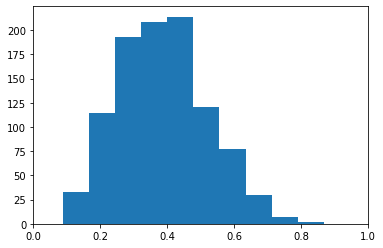

In [229]:
plt.hist(w)
plt.xlim(0, 1)

In [215]:
plt.hist([n for row in w for n in row])
plt.show()

TypeError: iteration over a 0-d tensor

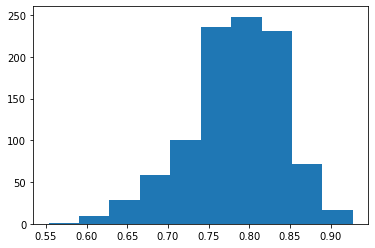

In [210]:
plt.hist([max(row) for row in w])
plt.show()

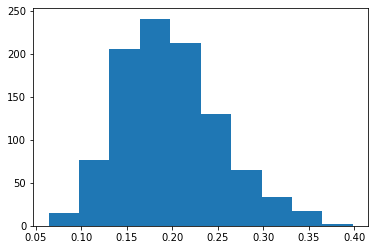

In [212]:
plt.hist([np.median(row) for row in w])
plt.show()

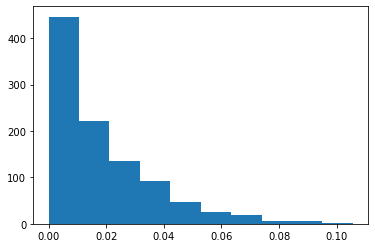

In [211]:
plt.hist([min(row) for row in w])
plt.show()

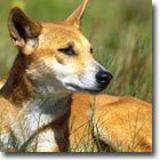

In [541]:
Image.open(files_u[0])

In [929]:
class ImageMixer:
    
    def __init__(self, n=3, dist=None):
        self.dist = dist or torch.distributions.beta.Beta(5, 8)
        self.n = n
        
    def transform(self, *images):
        w = self._generate_weights()
        return ((self._combine_images(images, w), *images), w)
        
    def _generate_weights(self):
        weights = np.zeros(self.n)
        p = self.dist.sample()
        indices = np.random.choice(self.n, size=2, replace=False)
        weights[indices] = p, 1-p
        return torch.tensor(weights)
    
    def _combine_images(self, images, weights):
#         img*w for img, w in zip(images, weights)
        images = torch.stack(images, dim=0)
#         return weights[(None,) * (images.dim()-1)]
        return (weights[:, None, None, None] * images).sum(0)
#         return (weights[(None,) * (images.dim()-1)].transpose(-1, 0) * images).sum(0)

In [930]:
xb = db.one_batch()
a, b, c, d = xb[0]
a.shape

torch.Size([3, 160, 160])

In [931]:
torch.tensor([0.85448831, 0., 0.14551167])[(None,)*3].transpose(-1, 0).shape

torch.Size([3, 1, 1, 1])

In [932]:
mixer = ImageMixer()
res, weights = mixer.transform(a, b, c)

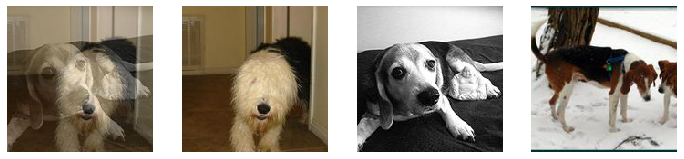

In [933]:
show_images(res)

In [934]:
weights

tensor([0.6378, 0.3622, 0.0000], dtype=torch.float64)

In [594]:
img = torch.randint(0, 4, (2, 3, 4, 4))
img

tensor([[[[0, 2, 3, 3],
          [2, 2, 3, 1],
          [3, 1, 0, 0],
          [1, 3, 2, 3]],

         [[1, 2, 3, 1],
          [1, 1, 2, 2],
          [2, 1, 1, 2],
          [0, 3, 0, 3]],

         [[0, 3, 3, 2],
          [3, 2, 3, 0],
          [2, 2, 2, 3],
          [3, 2, 1, 3]]],


        [[[1, 0, 2, 3],
          [2, 0, 0, 0],
          [3, 2, 0, 2],
          [3, 1, 3, 1]],

         [[2, 3, 0, 1],
          [2, 0, 0, 3],
          [0, 1, 1, 3],
          [0, 1, 1, 1]],

         [[3, 0, 2, 3],
          [3, 2, 1, 0],
          [1, 0, 2, 3],
          [2, 1, 0, 3]]]])

In [279]:
w = torch.tensor([2, 3])
w

tensor([2, 3])

In [306]:
w[(None,)*3].transpose(-1, 0)

torch.Size([2, 1, 1, 1])

In [280]:
w[:, None, None, None] * img

tensor([[[[0, 6, 6, 6],
          [4, 4, 4, 6],
          [6, 0, 4, 4],
          [2, 0, 0, 6]],

         [[6, 6, 6, 4],
          [4, 0, 0, 2],
          [0, 0, 2, 6],
          [0, 4, 4, 6]],

         [[0, 0, 2, 4],
          [4, 4, 6, 4],
          [2, 2, 6, 2],
          [6, 4, 0, 2]]],


        [[[6, 3, 3, 3],
          [9, 0, 0, 6],
          [6, 9, 6, 0],
          [3, 3, 9, 3]],

         [[3, 3, 9, 6],
          [0, 6, 3, 0],
          [9, 6, 3, 3],
          [6, 0, 0, 3]],

         [[0, 9, 0, 3],
          [0, 3, 0, 0],
          [3, 6, 3, 9],
          [0, 3, 3, 0]]]])

In [935]:
def load_img(path, shape):
    img = load_image(path).resize(shape)
    tns = TensorImage(img) / 255.
    return tns.permute(2, 0, 1)

In [985]:
class MixupDS(Dataset):
    
    def __init__(self, paths, shape=(160, 160), n=3, dist=None):
        self.paths = paths
        self.n = n
        self.mixer = ImageMixer(n=3, dist=None) # Require defaults for now while functionality is narrow.
        self.load_img = partial(load_img, shape=shape)
        
    def __len__(self):
        return len(self.paths) // self.n
    
    def __getitem__(self, i):
        images = map(self.load_img, self.paths[i:i+self.n])
        xb, yb = self.mixer.transform(*images)
        return torch.cat(xb, dim=-1), yb

In [986]:
ds = MixupDS(files_u)
len(ds)

2583

In [987]:
x, y = ds[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


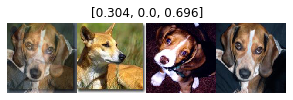

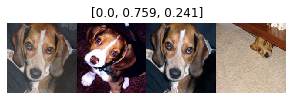

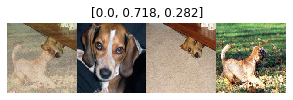

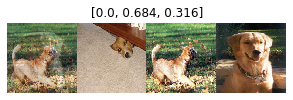

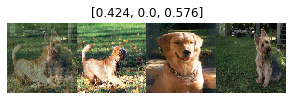

In [988]:
for i in range(5):
    imgs, w = ds[i]
    show_image(imgs)
    plt.title([round(x, 3) for x in w.tolist()])

In [989]:
batch = [ds[i] for i in range(3)]

In [990]:
*x, y = collate_fn(batch)
len(x)

1

In [925]:
torch.stack(ds[i][:-1]).shape

torch.Size([4, 3, 160, 160])

In [908]:
torch.stack(x, dim=-1).shape

torch.Size([3, 160, 160, 4])

In [992]:
shuffle = False
dl = TorchDataLoader(ds, batch_size=5, shuffle=shuffle)
dl

In [993]:
xb, yb = next(iter(dl))

In [994]:
len(xb)

5

In [995]:
type(xb)

torch.Tensor

In [996]:
xb.shape

torch.Size([5, 3, 160, 640])

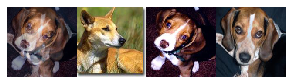

In [998]:
show_image(xb[0])

In [999]:
yb[0]

tensor([0.0000, 0.4803, 0.5197], dtype=torch.float64)

In [1000]:
yb.shape

torch.Size([5, 3])

In [1001]:
yb

tensor([[0.0000, 0.4803, 0.5197],
        [0.5639, 0.0000, 0.4361],
        [0.0000, 0.7125, 0.2875],
        [0.4722, 0.5278, 0.0000],
        [0.5117, 0.4883, 0.0000]], dtype=torch.float64)

In [1005]:
xn, xa, xb, xc = xb.chunk(4, dim=-1)

torch.Size([5, 3, 160, 160])
torch.Size([5, 3, 160, 160])
torch.Size([5, 3, 160, 160])
torch.Size([5, 3, 160, 160])


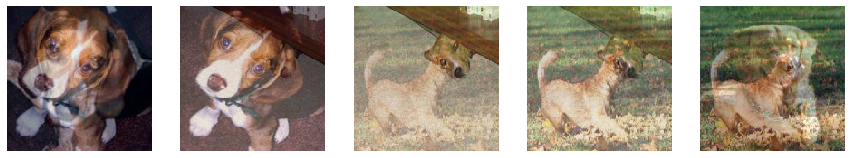

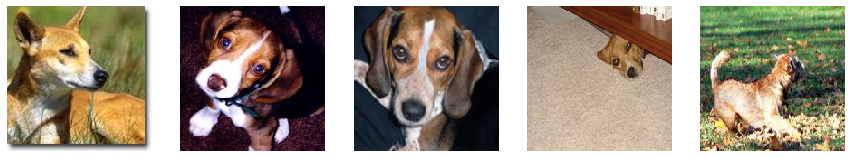

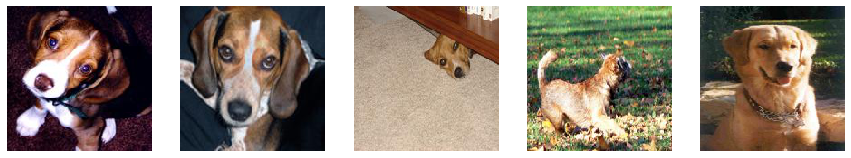

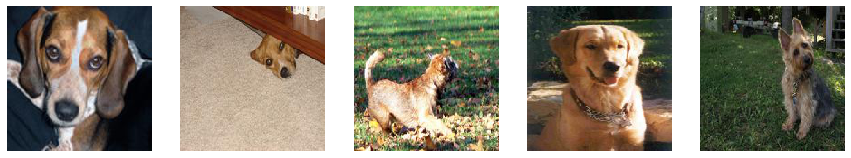

In [1009]:
for img in (xn, xa, xb, xc):
    print(img.shape)
    show_images(img)

tensor([[0.7189, 0.2811, 0.0000],
        [0.5664, 0.0000, 0.4336],
        [0.5843, 0.4157, 0.0000],
        [0.4970, 0.0000, 0.5030],
        [0.0000, 0.4860, 0.5140]], dtype=torch.float64)


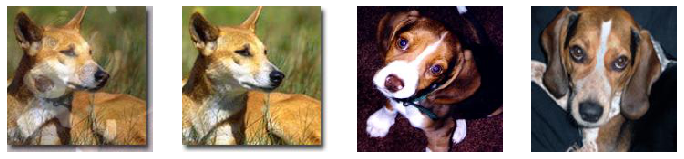

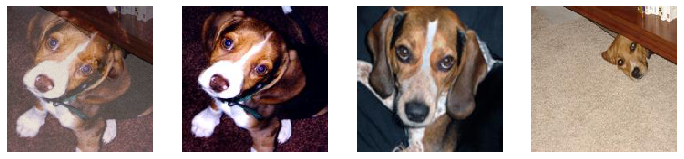

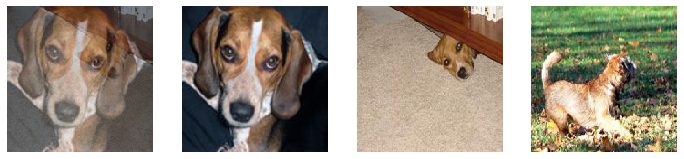

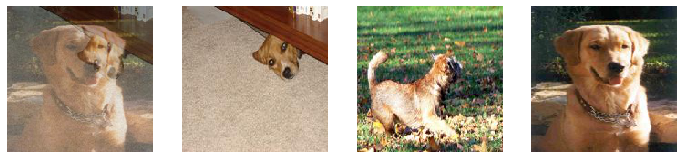

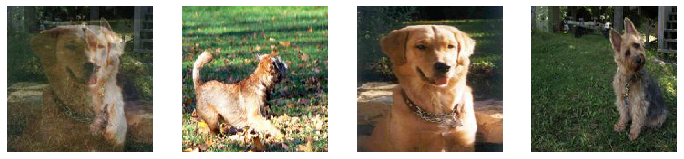

In [1017]:
for i, (xb, yb) in enumerate(dl):
    print(yb)
    for row in xb:
        show_images(row.chunk(4, dim=-1))
    if i == 0: break

# TODO: looks like some images may not have 3 channels. load_image() breaks.